In [15]:
# Implementing a U-net network on Bagls dataset.

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
# import tensorflow as tf
import albumentations as A
from PIL import Image
from sklearn.model_selection import train_test_split


In [16]:
data_dir = 'D:/Hamed/Forschungsproject/Hancock 2/Tiles_2.0_512_256_overfit'
tile_size1 = (256,256)
tile_size2 = (256,256,1)
input_shape = (256,256,3)
tile_type = 'Tiles_0.6_256_0_of'

 
x = []
y = []

for filename in natsorted(os.listdir(data_dir)):
    if filename.endswith('].png'):
        x.append(os.path.join(data_dir, filename))

    if filename.endswith('labelled.png'):
        y.append(os.path.join(data_dir, filename))

X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.01, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)


In [17]:
print("Dataset Sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")


Dataset Sizes:
Training set: 21 samples
Validation set: 3 samples
Test set: 1 samples


(256, 256) [0 3 7]


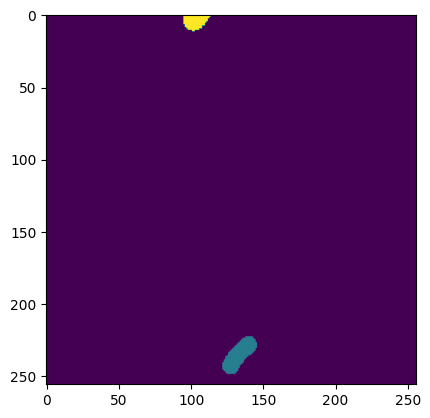

In [18]:
for i in range(len(Y_train)):
    
    lbl_arr = Image.open(Y_train[i])
    lbl_arr = lbl_arr.resize((256, 256))
    lbl_arr = np.array(lbl_arr)
    if len(np.unique(lbl_arr))>2:
        print(np.shape(lbl_arr),np.unique(lbl_arr))
        plt.imshow(lbl_arr)
        break

In [19]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, list_IDs, list_labels, batch_size=2, shuffle=True, aug=True):
        'Initialization'
        self.filter = A.Compose([
            A.HorizontalFlip(p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.VerticalFlip(p=0.2),
            A.RandomRotate90(p=0.1)
        ])
        self.class_names = class_names = [
            'background',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Bindegewebe',
            'X2 Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel längss',
            'Nerv']
        self.batch_size = batch_size
        self.list_labels = list_labels
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.aug = aug
        self.unique = np.arange(1, 13, 1)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_paths = [self.list_IDs[k] for k in indexes]
        list_label_paths = [self.list_labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_paths, list_label_paths)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_paths, list_label_paths):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        x_images = []
        y_images = []

        # Generate data
        for i, (sample_path, label_path) in enumerate(zip(list_IDs_paths, list_label_paths)):
            # Store sample
            img_arr = Image.open(sample_path)
            img_arr = img_arr.resize(tile_size1)
            img_arr = np.array(img_arr, dtype=np.float32)
            img_arr = np.divide(img_arr, np.max(img_arr))  # normalize

            # Store label
            lbl_arr = Image.open(label_path)
            lbl_arr = lbl_arr.resize(tile_size1)
            lbl_arr = np.array(lbl_arr)
            channels = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1], 12), dtype=np.float32)

            bg = np.zeros((np.shape(lbl_arr)[0], np.shape(lbl_arr)[1]))

            for i, value in enumerate(self.unique):
                channels[:, :, i] = (lbl_arr == value).astype(np.uint8) * 255

            bg = (lbl_arr == 0)
            bg = np.reshape(bg,tile_size2)
            lbl_arr = channels
            lbl_arr = np.concatenate((bg, lbl_arr), axis=2)

            lbl_arr[lbl_arr < 1] = 0
            lbl_arr[lbl_arr >= 1] = 1

            if self.aug:
                transformed = self.filter(image=img_arr, mask=lbl_arr)
                x_images.append(transformed['image'])
                y_images.append(transformed['mask'])
            else:
                x_images.append(img_arr)
                y_images.append(lbl_arr)

        # Stack x_images along a new axis
        x_images = np.stack(x_images, axis=0)
        y_images = np.stack(y_images, axis=0)

        return x_images, y_images

    def viz(self, x_images, y_images):
        'Visualizes original and transformed images'
        batch_size = len(x_images)
        for dx in range(batch_size):
            y_mask = y_images[dx]

            # Display original and transformed images side by side
            fig, axs = plt.subplots(1, 14, figsize=(20, 10))

            axs[0].imshow(x_images[dx])
            axs[0].set_title('img')
            axs[0].axis('off')

            for i in range(1, 14):
                axs[i].imshow(y_mask[:, :, i-1], cmap='gray')
                axs[i].axis('off')  # Remove axes
                axs[i].set_title(f'{self.class_names[i-1]}')
            plt.show()

        print(f'Batch shape {np.shape(x_images)} and for masks {np.shape(y_images)}')
        print(f'image shape {np.shape(x_images[dx])} and for masks {np.shape(y_images[dx])}')
        print(f'max value for images is {np.max(x_images[dx])} and for masks {np.max(y_images[dx])}')
        print(f'min value for images is {np.min(x_images[dx])} and for masks {np.min(y_images[dx])}')
        print(f'number of unique values in images is {len(np.unique(x_images[dx]))} and for masks {np.unique(y_images[dx])}')


In [26]:
test = DataGenerator(x,y,batch_size=24,aug=0)
a,b = test.__getitem__(0)
#test.viz(a,b)
np.shape(a)

(24, 256, 256, 3)

In [80]:

fil = 32
inputs = Input(input_shape)


# Contractive
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
conv4 = BatchNormalization()(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(fil*16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
conv5 = BatchNormalization()(conv5)

# Expansive
upconv1 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
up6 = UpSampling2D(size = (2,2))(upconv1)
merge6 = concatenate([conv4,up6], axis = 3)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(fil*8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
conv6 = BatchNormalization()(conv6)

upconv2 = Conv2D(fil*8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = UpSampling2D(size = (2,2))(upconv2)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(fil*4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
conv7 = BatchNormalization()(conv7)

upconv3 = Conv2D(fil*4, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = UpSampling2D(size = (2,2))(upconv3)
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(fil*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
conv8 = BatchNormalization()(conv8)


upconv4 = Conv2D(fil*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = UpSampling2D(size = (2,2))(upconv4)
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(fil, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = BatchNormalization()(conv9)


conv10 = Conv2D(13, 1, activation = 'softmax')(conv9)

model = Model(inputs = inputs, outputs = conv10)

#model.summary()




In [81]:
from keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
    monitor='loss', 
    min_delta=0.0001,
    patience=5,
    verbose=1, 
    mode='auto' 
)

from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore

loss = DiceLoss()
metric = IOUScore()

def custom_Diceloss(y_true, y_pred):
    y_true_exclude_first = y_true[:, :, :, 1:]
    y_pred_exclude_first = y_pred[:, :, :, 1:]
    return loss(y_true_exclude_first, y_pred_exclude_first)

DiceLoss = DiceLoss()
IOUscore1 = IOUScore(class_indexes=1, name='BG')
IOUscore2 = IOUScore(class_indexes=2, name='IOU_Tumor')
IOUscore3 = IOUScore(class_indexes=3, name='IOU_Stroma')
IOUscore4 = IOUScore(class_indexes=4, name='IOU_Necrosis')
IOUscore5 = IOUScore(class_indexes=5, name='IOU_Verhornung')
IOUscore6 = IOUScore(class_indexes=6, name='IOU_Blut')
IOUscore7 = IOUScore(class_indexes=7, name='IOU_Lockeres_Bindegewebe')
IOUscore8 = IOUScore(class_indexes=8, name='IOU_Zellreiches_Stroma')
IOUscore9 = IOUScore(class_indexes=9, name='IOU_Fettgewebe')
IOUscore10 = IOUScore(class_indexes=10, name='IOU_Muskel')
IOUscore11 = IOUScore(class_indexes=11, name='IOU_Cauter')
IOUscore12 = IOUScore(class_indexes=12, name='IOU_Muskel_längss')
IOUscore13 = IOUScore(class_indexes=13, name='IOU_Nerv')


In [82]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch >= 50 and epoch <51:
        return lr * 0.1
    else:
        return lr 

model.compile(optimizer=SGD(learning_rate=0.1, momentum=0.9, nesterov=False),
              loss=custom_Diceloss,
              metrics=[
                IOUscore1,
                IOUscore2,
                IOUscore3,
                IOUscore4,
                IOUscore5,
                IOUscore6,
                IOUscore7,
                IOUscore8,
                IOUscore9,
                IOUscore10,
                IOUscore11,
                IOUscore12,
                IOUscore13
              ])

history = model.fit(a,b,
                    epochs=200,
                    callbacks=[LearningRateScheduler(lr_scheduler)]
                    )


Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.9915 - BG: 0.0170 - IOU_Tumor: 0.0092 - IOU_Stroma: 0.0013 - IOU_Necrosis: 0.0029 - IOU_Verhornung: 0.0012 - IOU_Blut: 5.6901e-04 - IOU_Lockeres_Bindegewebe: 0.0073 - IOU_Zellreiches_Stroma: 9.6748e-11 - IOU_Fettgewebe: 0.0117 - IOU_Muskel: 6.2063e-11 - IOU_Cauter: 7.2527e-11 - IOU_Muskel_längss: 6.3908e-04 - IOU_Nerv: 1.0000 - lr: 0.1000
Epoch 2/200
1/1 [==============================] - 0s 205ms/step - loss: 0.9913 - BG: 0.0173 - IOU_Tumor: 0.0096 - IOU_Stroma: 0.0012 - IOU_Necrosis: 0.0029 - IOU_Verhornung: 0.0012 - IOU_Blut: 5.3779e-04 - IOU_Lockeres_Bindegewebe: 0.0076 - IOU_Zellreiches_Stroma: 9.6702e-11 - IOU_Fettgewebe: 0.0118 - IOU_Muskel: 6.1357e-11 - IOU_Cauter: 7.2333e-11 - IOU_Muskel_längss: 6.6208e-04 - IOU_Nerv: 1.0000 - lr: 0.1000
Epoch 3/200
1/1 [==============================] - 0s 201ms/step - loss: 0.9915 - BG: 0.0166 - IOU_Tumor: 0.0091 - IOU_Stroma: 0.0012 - IOU_Necrosis: 0.0028 - IOU_Verhornu

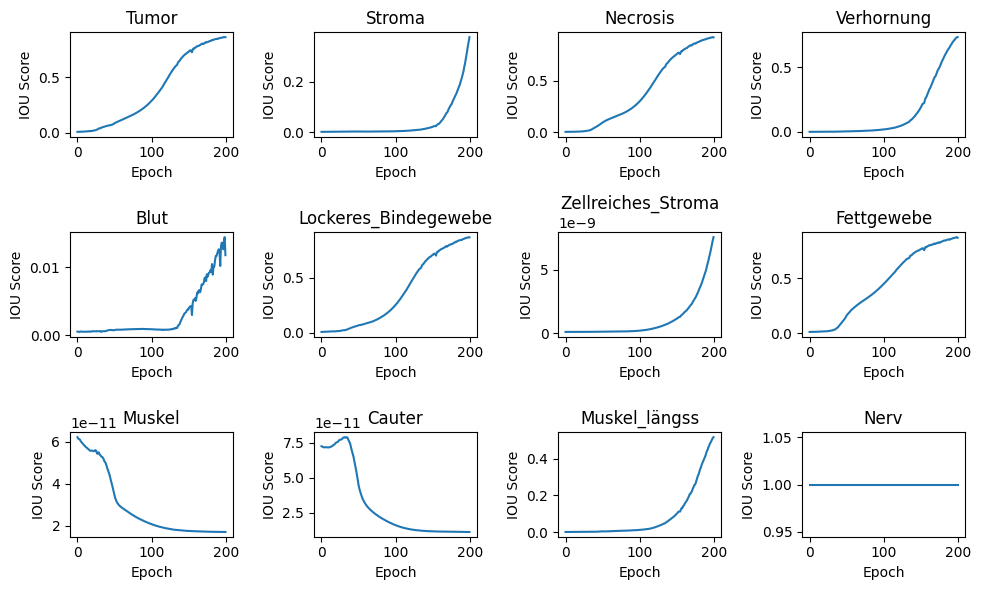

In [83]:
#how was the network on each epoch?

class_names = [
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längss',
            'Nerv']

fig, axes = plt.subplots(3, 4, figsize=(10, 6))
axes = axes.flatten()

for i, class_name in enumerate(class_names):
    metric_name = 'IOU_' + class_name
    val_name = 'val_IOU_' + class_name
    axes[i].plot(history.history[metric_name])
    #axes[i].plot(history.history[val_name])
    axes[i].set_title(class_name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('IOU Score')

# Hide unused subplots
for j in range(len(class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
#plt.savefig('./attempts/plots_OF_0.6/64SGDM_0.6_lr=0.01.png') 
plt.show()

In [71]:
DataGen = DataGenerator(X_test, Y_test, batch_size=len(X_test),aug=True)
a, b =DataGen.__getitem__(0)
score = model.evaluate(a,b)


2/2 [==============================] - 0s 90ms/step - loss: 0.5489 - BG: 0.5847 - IOU_Tumor: 0.5415 - IOU_Stroma: 2.0696e-07 - IOU_Necrosis: 0.5890 - IOU_Verhornung: 0.5000 - IOU_Blut: 0.2817 - IOU_Lockeres_Bindegewebe: 0.5298 - IOU_Zellreiches_Stroma: 7.4979e-10 - IOU_Fettgewebe: 0.0942 - IOU_Muskel: 1.0000 - IOU_Cauter: 8.9354e-12 - IOU_Muskel_längss: 0.5000 - IOU_Nerv: 1.0000


In [72]:
class_names = [
            'BG',
            'Tumor',
            'Stroma',
            'Necrosis',
            'Verhornung',
            'Blut',
            'Lockeres_Bindegewebe',
            'Zellreiches_Stroma',
            'Fettgewebe',
            'Muskel',
            'Cauter',
            'Muskel_längss',
            'Nerv']

1/1 [==============================] - 0s 36ms/step
(1, 256, 256, 13)


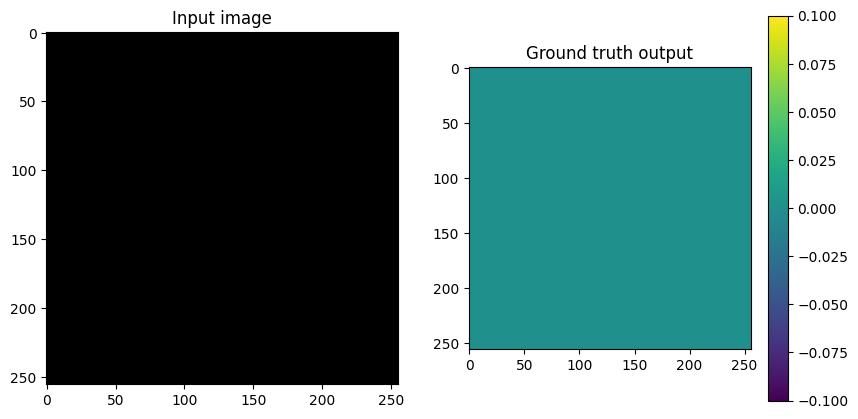

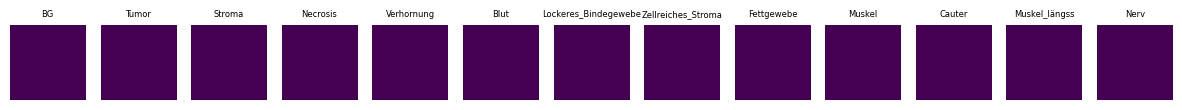

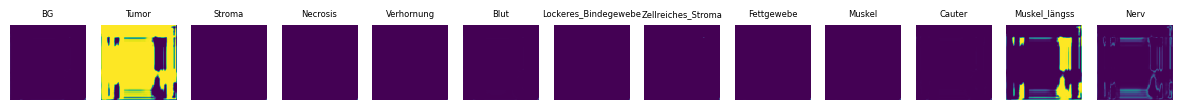

In [98]:
# Normal
DataGen = DataGenerator(X_test, Y_test, batch_size=1, aug=False)
#img, mask = DataGen.__getitem__(3)
img = np.zeros((1,256, 256, 3))
mask = np.zeros((1, 256, 256, 13))
y_pred = model.predict(img)



print(np.shape(y_pred))

# Create a figure with three subplots arranged horizontally
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image in the first subplot
axs[0].imshow(img[0])
axs[0].set_title('Input image')

# Create an empty array to store the changed image
changed_img = np.zeros((13, 256, 256, 1), dtype=np.uint8)

# Iterate over the channels and assign values accordingly
for i in range(13):
    temp = (mask[:, :, :, i] > 0.).astype(np.uint8)
    changed_img[:, :, :, 0] += temp * (i + 1)


# Plot the ground truth output in the second subplot
im = axs[1].imshow(changed_img[0])
axs[1].set_title('Ground truth output')
plt.colorbar(im, ax=axs[1])

##################################

# Create the subplots
fig, axs = plt.subplots(1, 13, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(mask[0][:, :, i])
    ax.axis('off')
    ax.set_title(f'{class_names[i]}', fontsize=6)

plt.show()

###########################################

# Create the subplots
fig, axs = plt.subplots(1, 13, figsize=(15, 5))

# Loop through each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(y_pred[0][:, :, i])
    ax.axis('off')
    ax.set_title(f'{class_names[i]}', fontsize=6)

plt.show()


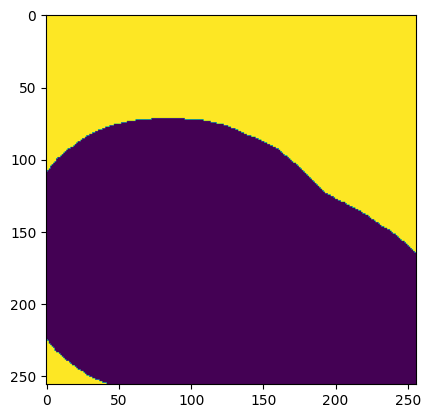

In [44]:
plt.imshow(mask[0,:,:,0])
